## INSTALLING AND IMPORTING LIBRARIES

In [23]:
!pip install Sastrawi
!pip install pytypo

In [24]:
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
import tensorflow as tf
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
import pytypo
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # Added
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import pickle
import re
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from tensorflow.keras.models import load_model

In [25]:
#STOPWORDS IN BAHASA

stop_factory = StopWordRemoverFactory()
more_stopword = ["dengan", "ia", "bahwa", "oleh"]
data = stop_factory.get_stop_words()+more_stopword
stopword = stop_factory.create_stop_word_remover()
print(data)

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'ingin', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', '

## LOAD DATASET AND DATA UNDERSTANDING

In [26]:
df = pd.read_csv('/content/drive/MyDrive/LSTM/sentiment.csv', sep =';', encoding = 'latin1', names = ('text', 'sentiment'))

In [27]:
df.head()

,text,sentiment
0,Sebagai perusahaan asuransi jiwa berbasis digi...,positive
1,Jakarta CNN Indonesia Presiden Joko Widodo me...,positive
2,JAKARTA Bandara SoekarnoHatta dinobatkan seba...,positive
3,Kamis 02 Sep 2021 Jawa Pos Radar Radar Menu ...,positive
4,Pemerintah melaksanakan berbagai program dan k...,positive


In [28]:
df.columns

Index(['text', 'sentiment'], dtype='object')

In [29]:
data = df[['text','sentiment']]
data = data.dropna()
data.head(1000)

,text,sentiment
0,Sebagai perusahaan asuransi jiwa berbasis digi...,positive
1,Jakarta CNN Indonesia Presiden Joko Widodo me...,positive
2,JAKARTA Bandara SoekarnoHatta dinobatkan seba...,positive
3,Kamis 02 Sep 2021 Jawa Pos Radar Radar Menu ...,positive
4,Pemerintah melaksanakan berbagai program dan k...,positive
...,...,...
995,Akhirnya setelah proses konstruksi yang memaka...,neutral
996,Rupanya dengan insiden dua Bobotoh meninggal d...,neutral
997,Laut Natuna atau Laut China Selatan memiliki k...,neutral
998,Kamis 23 Juni 2022 Network Pikiran Rakyat Gowa...,neutral


In [30]:
data.shape

(1500, 2)

In [31]:
data.dtypes

,0
text,object
sentiment,object


In [32]:
# Use .loc in a single step to assign values, avoiding chained assignment warnings
data.loc[data['sentiment'] == "positive", 'sentiment'] = "positive"
data.loc[data['sentiment'] == "neutral", 'sentiment'] = "neutral"
data.loc[data['sentiment'] == "negative", 'sentiment'] = "negative"

data.reset_index(inplace=True)
data.drop('index', axis='columns', inplace=True)

In [33]:
data.sentiment.value_counts()

,count
sentiment,
positive,500
neutral,500
negative,500


In [34]:
def text_sentiment(index):
    example = data[data.index == index][['text', 'sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print()
        print('Category:', example[1])

In [35]:
text_sentiment(10)

BANDA ACEH  Gubernur Aceh Ir H Nova Iriansyah MT kembali mengeluarkan Instruksi Gubernur (Ingub) tentang Perpanjangan Pemberlakuan Pembatasan Kegiatan Masyarakat (PPKM) Berbasis Mikro Level 4 Level 3 dan Level 2 serta Mengoptimalkan Posko Penanganan Covid19 di Tingkat Gampong untuk Pengendalian Penyebaran Covid19. Ingub Nomor 19 INSTR Tahun 2021 itu ditetapkan pada 7 September 2021 dan berlaku sampai 20 September mendatang. Kepala Biro Humas dan Protokol (Karo Humpro) Setda Aceh Muhammad Iswanto SSTP MM kepada Serambi  Selasa (7/9/2021) mengatakan Instruksi Gubernur itu dikeluarkan menindaklanjuti Instruksi Menteri Dalam Negeri Nomor 40 Tahun 2021 dan Nomor 41 Tahun 2021. "Ingub itu ditujukan kepada para bupati dan wali kota serta para Kepala Satuan Kerja Perangkat Aceh (SKPA) " ujarnya. Iswanto menerangkan Ingub tersebut memuat sejumlah ketentuan untuk diterapkan oleh para bupati dan wali kota serta SKPA terkait. Pada poin kesatu disebutkan bahwa bupati/wali kota mengatur PPKM Mikro s

## CLEANING TEXT

In [36]:
#DEFINE CLEANING THE TEXT

def clean(text) :

  text_cleaning_re = "@\S+|https?:\S+|http?:\S|[#]+|[^A-Za-z0-9]+"
  text_cleaning_hash = "#[A-Za-z0-9]+"
  text_cleaning_num = "(^|\W)\d+"
  text_cleaning_space = "xa0"

  text = re.sub(text_cleaning_hash, " ", str(text)).strip()
  text = re.sub(text_cleaning_num, " ", str(text)).strip()
  text = re.sub(text_cleaning_re, " ", str(text)).strip()
  text = re.sub(text_cleaning_space, " ", str(text)).strip()

  text = text.strip()

  out = []
  for word in text.split() :
    out.append(word)

  return pytypo.correct_sentence(" ".join(out).strip())

In [37]:
data.apply(clean)

,0
text,Sebagai perusahaan asuransi jiwa berbasis digi...
sentiment,positive positive positive positive positive n...


## TOKENIZING

In [38]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each text
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 26396 unique tokens.


In [39]:
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1500, 250)


In [40]:
# save the tokenizer.pkl

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [41]:
Y = pd.get_dummies(data['sentiment']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1500, 3)


## SPLITTING AND MODELING

In [42]:
# splitting dataset

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.05, random_state = 30)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape #, X_val.shape, Y_val.shape
# print(X_train.shape,Y_train.shape)
# print(X_test.shape,Y_test.shape)

((1425, 250), (1425, 3), (75, 250), (75, 3))

In [43]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [44]:
epochs = 5
batch_size = 64
callbacks = EarlyStopping(monitor = 'val_loss', patience = 3, min_delta = 0.0001)

history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch_size, validation_split = 0.1, verbose = 2)

Epoch 1/5
21/21 - 46s - 2s/step - accuracy: 0.3955 - loss: 1.0930 - val_accuracy: 0.5175 - val_loss: 1.0706
Epoch 2/5
21/21 - 19s - 911ms/step - accuracy: 0.6069 - loss: 0.9854 - val_accuracy: 0.5385 - val_loss: 1.0025
Epoch 3/5
21/21 - 18s - 849ms/step - accuracy: 0.7488 - loss: 0.7635 - val_accuracy: 0.6084 - val_loss: 0.9664
Epoch 4/5
21/21 - 22s - 1s/step - accuracy: 0.8151 - loss: 0.5714 - val_accuracy: 0.5734 - val_loss: 0.9499
Epoch 5/5
21/21 - 17s - 808ms/step - accuracy: 0.8822 - loss: 0.3864 - val_accuracy: 0.5874 - val_loss: 0.9479


In [45]:
accr = model.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.7182 - loss: 0.6981
Test set
  Loss: 0.672
  Accuracy: 0.733


<ipython-input-46-b001209db311>:6: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



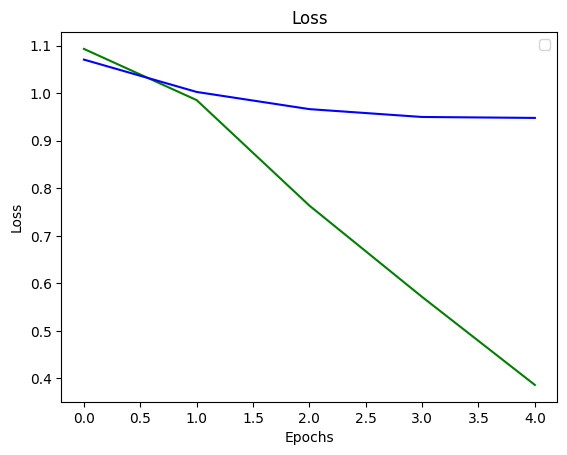

In [46]:
plt.title('Loss')
plt.plot(history.history['loss'], 'g')
plt.plot(history.history['val_loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

<ipython-input-47-dd865d02a897>:6: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



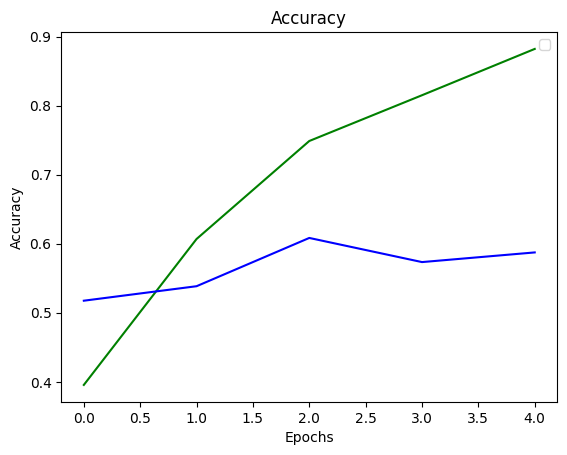

In [47]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], 'g')
plt.plot(history.history['val_accuracy'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

In [48]:
text = ['Koarmada I Pangkalan TNI Angkatan Laut (Lanal) Tanjung Balai Asahan berhasil menggagalkan kapal jenis sampan kaluk yang menyelundupkan narkoba melalui alur Sungai Bagan Asahan Selasa (21/06/2022) Tim Satgas Intelijen Lanal TBA menerima informasi bahwa akan melintas sebuah perahu jenis sampan kaluk dengan ciri-ciri berwarna lambung lis biru laut. Tim adakan briefing dan langsung melakukan patroli di sekitar alur sungai bagan Asahan. Di pagi hari Tim Satgas Lanal TBA mencurigai sebuah kapal yang sesuai ciri-ciri dari informasi yang diterima maka Patkamla melakukan pengejaran dan pemberhentian terhadap kapal tersebut. Setelah diadakan pemeriksaan muatan kapal ditemukan kotak fiber warna kuning diduga berisi 19.980 gram ekstasi dan 29 bungkus sabu-sabu. Selanjutnya Kapal dibawa menuju ke Lanal Tanjung Balai Asahan guna pemeriksaan lebih lanjut. Panglima Koarmada I (Pangkoarmada I) Laksamana Muda TNI Arsyad Abdullah secara terpisah mengatakan "Dalam melaksanakan tugas penegakan kedaulatan dan hukum serta menjaga keamanan dan keselamatan di laut TNI Angkatan laut senantiasa melakukan secara profesional dan proporsional" Dikatakan lebih lanjut bahwa komitmen TNI AL sudah sangat jelas dan tegas tidak ada kompromi dengan segala bentuk upaya yang mengancam kedaulatan termasuk tindak pidana dan pelanggaran di Laut. "Dengan menggagalkan kapal jenis sampan kaluk untuk menyelundupkan narkoba merupakan salah satu bentuk kehadiran TNI Angkatan Laut melakukan Patroli guna mencegah segala bentuk pelanggaran sesuai dengan komitmen Kepala Staf TNI Angkatan Laut Laksamana TNI Yudo Margono" pungkasnya. ***']
seq = tokenizer.texts_to_sequences(text)
padded = pad_sequences(seq, maxlen = MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
sentiment = ['positive', 'neutral', 'negative']
print(pred, sentiment[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
[[0.00533472 0.00480472 0.9898606 ]] negative


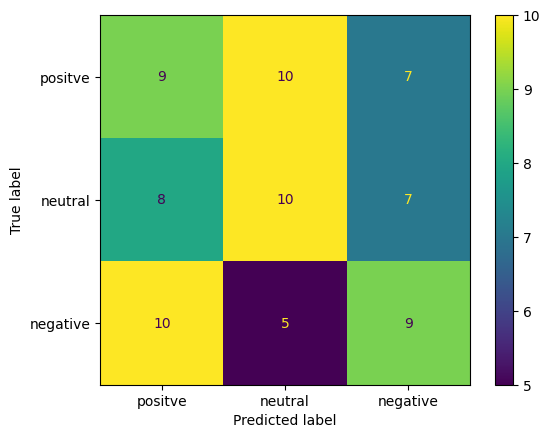

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = ['positve', 'neutral', 'negative']
Y_train = Y_train.reshape(75,57)

cm = confusion_matrix(Y_test.argmax(axis=1), Y_train.argmax(axis=1))
cm_display = ConfusionMatrixDisplay(cm, display_labels = labels).plot()

## SAVE THE MODEL

In [50]:
model = load_model("/content/drive/MyDrive/LSTM/model.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning:

Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 

